## 自编码器（AutoEncoder）
> 无监督学习,由 encoder和decoder组成
- encoder将原始表示编码成隐层表示
- decoder将隐层表示解码成原始表示
- 训练目标为最小化重构误差

## 准备MNIST数据

In [11]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

### 将像素归一化到0至1

In [7]:
# 加载数据
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
#reshape 重塑为 N*1*28*28思维tensor
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

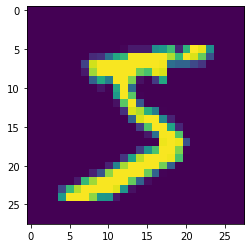

In [13]:
%matplotlib inline
img = x_train[0].reshape((28, 28))
plt.imshow(img)

# 添加白噪声

In [18]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0, 1)
x_test_noisy = np.clip(x_test_noisy, 0, 1)

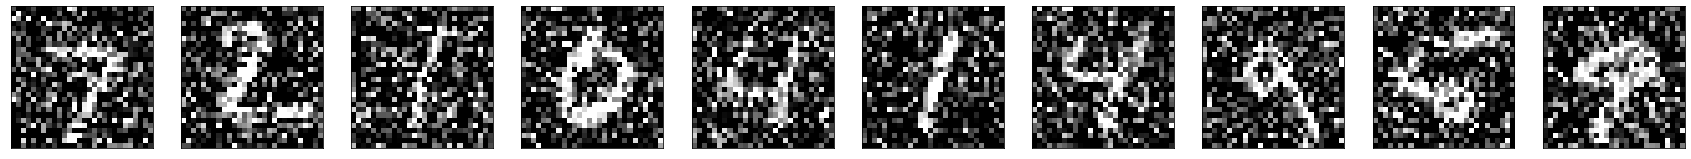

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

n = 10
plt.figure(figsize=(30, 3))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 模型实现

In [26]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, load_model

input_img = Input(shape=(28, 28, 1,))

## encoder，由两个3x3x32的卷积核两个2x2最大池化组成

In [27]:
x = Conv2D(32, (3,3), padding='same', activation='relu')(input_img) # 32*28*28
x = MaxPooling2D((2,2), padding='same')(x)# 32*14*14
x = Conv2D(32,(3, 3), padding='same', activation='relu')(x)# 32*14*14
encoded = MaxPooling2D((2, 2), padding='same')(x)#32*7*7

Instructions for updating:
Colocations handled automatically by placer.


## decoder，由两个3x3x32的卷积和两个2x2的上采样组成

In [28]:
# 7 * 7 *32
x = Conv2D(32, (3,3), padding='same', activation='relu')(encoded) # 32*7*7
x = UpSampling2D(size=(2,2))(x)# 32*14*14
x = Conv2D(32, (3,3), padding='same', activation='relu')(x) # 32*14*14
x = UpSampling2D(size=(2,2))(x)#32*28*28
decoded = Conv2D(1, (3,3), padding='same', activation='sigmoid')(x)# 1*28*28

## 链接输入输出，构成自编码器并编译

In [39]:
autoencoder = Model(input_img, decoded)
autoencoder.summary()
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 32)        0         
__________

## 使用训练集作为输入和输出进行训练，使用测试集进行校验

In [32]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))
autoencoder.save('autoencoder.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 124s 2ms/step - loss: 0.1053 - val_loss: 0.1050
Epoch 2/100
60000/60000 [==============================] - 158s 3ms/step - loss: 0.1038 - val_loss: 0.1024
Epoch 3/100
60000/60000 [==============================] - 133s 2ms/step - loss: 0.1027 - val_loss: 0.1004
Epoch 4/100
60000/60000 [==============================] - 127s 2ms/step - loss: 0.1017 - val_loss: 0.1006
Epoch 5/100
60000/60000 [==============================] - 114s 2ms/step - loss: 0.1013 - val_loss: 0.0998
Epoch 6/100
60000/60000 [==============================] - 142s 2ms/step - loss: 0.1007 - val_loss: 0.0997
Epoch 7/100
60000/60000 [==============================] - 146s 2ms/step - loss: 0.1003 - val_loss: 0.0993
Epoch 8/100
60000/60000 [==============================] - 106s 2ms/step - loss: 0.0998 - val_loss: 0.0983
Epoch 9/100
60000/60000 [==============================] - 120s 2ms/step - loss: 0.0994 - val_

## 对比加噪和原始图片

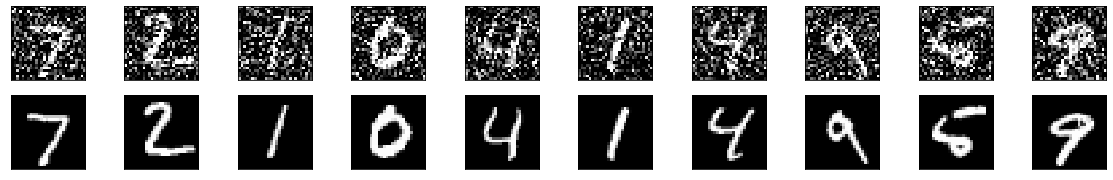

In [36]:
# 加载模型
autoencoder = load_model('autoencoder.h5')

# 预测图片
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10 
plt.figure(figsize=(20, 3))

for i in range(n):
    # 展示原始噪声图
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # 展示去噪图片
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(x_test[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()